In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time


In [2]:
data_dir = './RAFDB'
batch_size = 64
num_classes = 7

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                     
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))     
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Loaded pretrained weights for efficientnet-b0


In [4]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=7):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct.double() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [5]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer)

Epoch 1/50 | Train Loss: 1.3290, Acc: 0.5296 | Val Loss: 0.9787, Acc: 0.6509


Epoch 2/50 | Train Loss: 0.8326, Acc: 0.7091 | Val Loss: 0.7048, Acc: 0.7529


Epoch 3/50 | Train Loss: 0.6448, Acc: 0.7744 | Val Loss: 0.6007, Acc: 0.7849


Epoch 4/50 | Train Loss: 0.5244, Acc: 0.8178 | Val Loss: 0.5568, Acc: 0.7992


Epoch 5/50 | Train Loss: 0.4373, Acc: 0.8426 | Val Loss: 0.5448, Acc: 0.8057


Epoch 6/50 | Train Loss: 0.3592, Acc: 0.8732 | Val Loss: 0.5303, Acc: 0.8162


Epoch 7/50 | Train Loss: 0.3069, Acc: 0.8950 | Val Loss: 0.5280, Acc: 0.8214


Epoch 8/50 | Train Loss: 0.2516, Acc: 0.9138 | Val Loss: 0.5281, Acc: 0.8318


Epoch 9/50 | Train Loss: 0.2129, Acc: 0.9274 | Val Loss: 0.5724, Acc: 0.8175


Epoch 10/50 | Train Loss: 0.1768, Acc: 0.9399 | Val Loss: 0.5531, Acc: 0.8315


Epoch 11/50 | Train Loss: 0.1461, Acc: 0.9518 | Val Loss: 0.5961, Acc: 0.8259


Epoch 12/50 | Train Loss: 0.1219, Acc: 0.9573 | Val Loss: 0.6299, Acc: 0.8272


Epoch 13/50 | Train Loss: 0.1132, Acc: 0.9615 | Val Loss: 0.6243, Acc: 0.8312


Epoch 14/50 | Train Loss: 0.1009, Acc: 0.9660 | Val Loss: 0.6323, Acc: 0.8227
Early stopping


In [6]:
from sklearn.metrics import classification_report
import pandas as pd


model.eval()
all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print(report_df)



              precision    recall  f1-score      support
1              0.748691  0.869301  0.804501   329.000000
2              0.577465  0.554054  0.565517    74.000000
3              0.576389  0.518750  0.546053   160.000000
4              0.943132  0.909705  0.926117  1185.000000
5              0.781563  0.815900  0.798362   478.000000
6              0.743243  0.679012  0.709677   162.000000
7              0.787078  0.788235  0.787656   680.000000
accuracy       0.822686  0.822686  0.822686     0.822686
macro avg      0.736794  0.733565  0.733983  3068.000000
weighted avg   0.824019  0.822686  0.822535  3068.000000


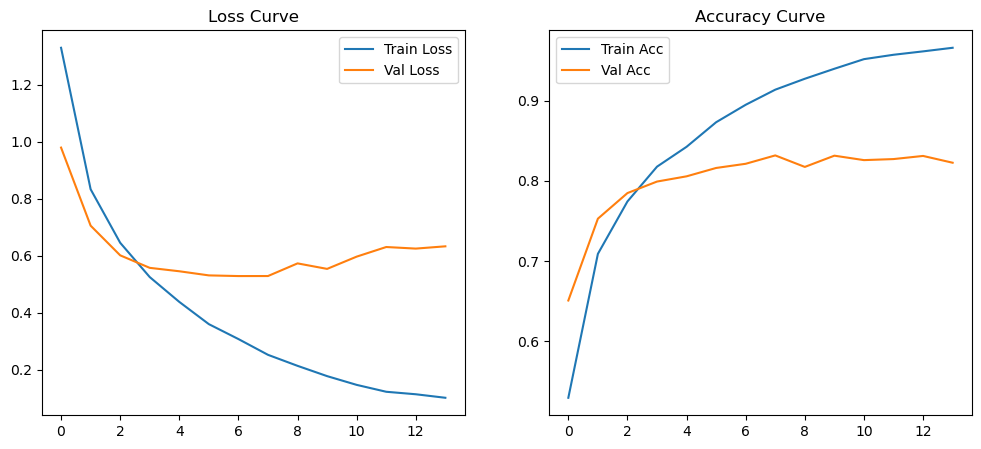

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


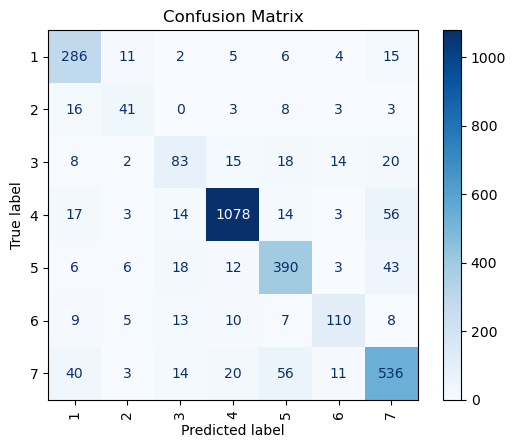

In [8]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')  
plt.title("Confusion Matrix")
plt.show()


Correct Predictions:


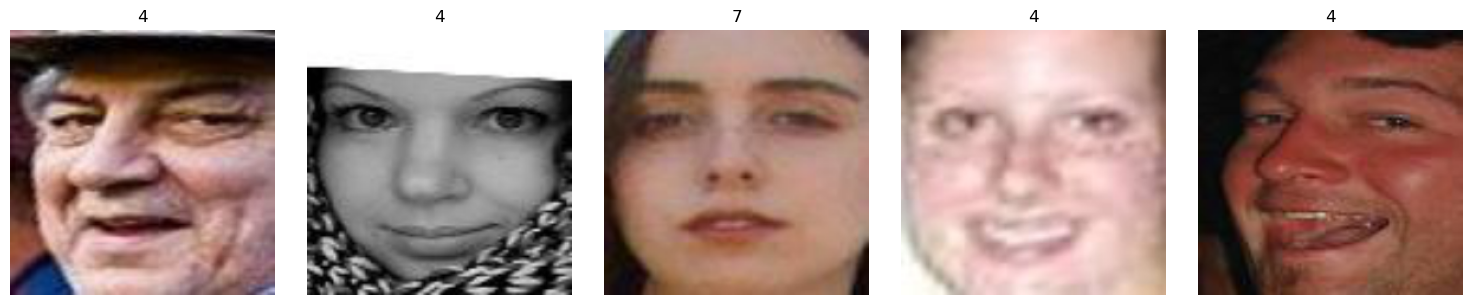

Incorrect Predictions:


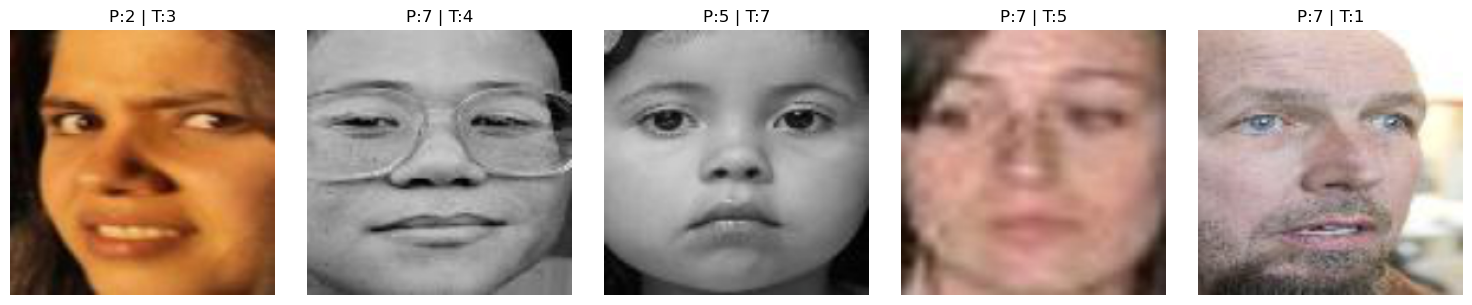

In [9]:
import random

def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

correct, incorrect = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(inputs.size(0)):
            if preds[i].cpu() == labels[i]:
                correct.append((inputs[i].cpu(), preds[i].item()))
            else:
                incorrect.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))

# Show 5 correct
print("Correct Predictions:")
correct_samples = random.sample(correct, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    img = unnormalize(correct_samples[i][0])
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.set_title(f'{class_names[correct_samples[i][1]]}')
plt.tight_layout()
plt.show()

# Show 5 incorrect
print("Incorrect Predictions:")
incorrect_samples = random.sample(incorrect, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    img = unnormalize(incorrect_samples[i][0])
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    pred, true = class_names[incorrect_samples[i][1]], class_names[incorrect_samples[i][2]]
    ax.imshow(inp)
    ax.set_title(f'P:{pred} | T:{true}')
plt.tight_layout()
plt.show()
